### Second Project

In [145]:
using Plots, ROCAnalysis, GLM, MLBase, Lathe, Distributions, LaTeXStrings, CSV, DataFrames, StatsBase, Missings, XLSX, Dates, HTTP, Permutations, Combinatorics, StatsBase
using IJulia: readprompt
theme(:dark)

In [14]:
dff = DataFrame(XLSX.readtable("crypto_currency.xlsx", "Sheet1")...)

,name,ticket,market cap,last price($)
,Any,Any,Any,Any
1,Bitcoin,BTC,750B,39K
2,Ethereum,ETH,360B,3K
3,Ripple,XRP,50B,0.7
4,Solana,SOL,34B,100
5,Terra,LUNA,32B,91
6,Cardano,ADA,30B,0.9
7,Avalanche,AVAX,20B,73
8,Polkadot,DOT,19B,19
9,Dogecoin,DOGE,18B,0.13


In [15]:
dff.ticket

10-element Vector{Any}:
 "BTC"
 "ETH"
 "XRP"
 "SOL"
 "LUNA"
 "ADA"
 "AVAX"
 "DOT"
 "DOGE"
 "MATIC"

In [18]:
selected_rows = findall(x->x ∈ sort(dff."market cap", rev=true)[1:5], dff."market cap")
top_five=dff[selected_rows,:]
for i in top_five."last price(\$)"
    if typeof(i) == String && contains(i, "K") == true
        replace!(top_five."last price(\$)", i=>parse(Int, chop(i))*1000)
    end
end
top_five

,name,ticket,market cap,last price($)
,Any,Any,Any,Any
1,Bitcoin,BTC,750B,39000
2,Ethereum,ETH,360B,3000
3,Ripple,XRP,50B,0.7
4,Solana,SOL,34B,100
5,Terra,LUNA,32B,91


##### *sclaing data*
$$
x := \frac{x - \mu}{\sigma}
$$

##### *Functions*

In [19]:
# removing nulls and substituing them with the average value
function string_remover(df :: DataFrame, col_ :: Integer)
    list_ = [0.0 for i in 1:366]
    sum=0.0
    tot=0.0
    for (n, value) in enumerate(df[!, col_])
        if value != "null"
            list_[n]=parse(Float64, value) 
            sum += list_[n]
            tot += 1  
        end
    end
    avg = sum/tot
    list_[findall(x->x==0.0, list_)] .= avg
    return list_
end
# calculating return values
function return_cal(df :: DataFrame)
    r_list = []
    for i in 2:11
        temp=[]
        for j in 1:365
            r = (df[j,i] - df[j+1,i])/ df[j+1,i]
            push!(temp, r)
        end
        push!(r_list, temp)
    end
    return r_list
end
# calculating the Cumulative return 
function cumulative_return(r_list)
    cu_r_list = []
    for i in 1:10
        multi=1
        for j in 1:length(r_list[i])
            multi *= (r_list[i][j] + 1)
        end
        push!(cu_r_list, multi - 1)
    end
    return cu_r_list
end

cumulative_return (generic function with 1 method)

### Q1

In [20]:
coin_symbols = ["BTC", "ETH", "XRP", "SOL", "LUNA", "ADA", "AVAX", "DOT", "DOGE", "MATIC" ]
start_date = "2021-01-01"
end_date = "2022-01-01"

"2022-01-01"

In [21]:
api_key = "052E2ECA-27A4-4E59-AD69-DAFDD269B5BE"

api_address = "https://rest.coinapi.io/v1/exchangerate/"
api_params = "/USD/history?period_id=1DAY&limit=2000&output_format=csv"

api_time(sdate, edate) = "&time_start=$(sdate)&time_end=$(edate)"

for symbol in coin_symbols
    write("$symbol.csv", HTTP.get(
        api_address * symbol * api_params * api_time(start_date, end_date),
        ["X-CoinAPI-Key" => api_key]).body)
end

In [22]:
df = DataFrame("Date" => reverse!(collect(Date(2021,01,01):Day(1):Date(2022,01,01))),
     "BTC" => reverse!(vec(convert(Array, select!(CSV.read("BTC.csv", DataFrame), "rate_close")))),
     "ETH"=> reverse!(vec(convert(Array, select!(CSV.read("ETH.csv", DataFrame), "rate_close")))), 
     "XRP"=> reverse!(vec(convert(Array, select!(CSV.read("XRP.csv", DataFrame), "rate_close")))),
     "SOL"=> reverse!(vec(convert(Array, select!(CSV.read("SOL.csv", DataFrame), "rate_close")))), 
     "LUNA"=> reverse!(vec(convert(Array, select!(CSV.read("LUNA.csv", DataFrame), "rate_close")))),
     "ADA"=> reverse!(vec(convert(Array, select!(CSV.read("ADA.csv", DataFrame), "rate_close")))), 
     "AVAX"=> reverse!(vec(convert(Array, select!(CSV.read("AVAX.csv", DataFrame), "rate_close")))), 
     "DOT"=> reverse!(vec(convert(Array, select!(CSV.read("DOT.csv", DataFrame), "rate_close")))),
     "DOGE"=> reverse!(vec(convert(Array, select!(CSV.read("DOGE.csv", DataFrame), "rate_close")))), 
     "MATIC"=> reverse!(vec(convert(Array, select!(CSV.read("MATIC.csv", DataFrame), "rate_close")))))

#preprocessing data


,Date,BTC,ETH,XRP,SOL,LUNA,ADA,AVAX,DOT
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2022-01-01,46181.5,3675.38,0.829368,169.98,85.4733,1.30796,109.436,26.6559
2,2021-12-31,46175.7,3675.22,0.829491,169.867,85.4261,1.30615,109.415,26.6477
3,2021-12-30,47144.6,3711.54,0.838914,172.593,84.7173,1.35927,101.726,27.5511
4,2021-12-29,46450.4,3628.43,0.816511,170.774,84.1641,1.33047,103.033,26.741
5,2021-12-28,47565.5,3797.55,0.851919,177.358,85.3572,1.40073,107.135,27.8798
6,2021-12-27,50702.3,4041.64,0.926585,195.661,90.891,1.51408,113.752,30.94
7,2021-12-26,50814.2,4066.1,0.920693,198.048,99.7597,1.45519,115.186,31.3552
8,2021-12-25,50435.6,4095.73,0.925013,193.072,98.2836,1.45388,114.931,28.8548
9,2021-12-24,50821.5,4047.17,0.910808,190.375,96.0153,1.39114,115.038,28.158


In [ ]:
# Polkadot_ = string_remover(df, 9)
# # deleting the previous column and adding the new one
# dff = select!(df, Not(:Polkadot))
# #insert!(df, 9, Polkadot_, :Polkadot)
# dff.Polkadot = Polkadot_

In [ ]:
# for i in 2:10
#     replace!(x -> x == "null" ? 0.0 : x , df[!,i])
# end

In [23]:
for i in 2:11
    replace!(x -> (x - mean(df[!,i]))/var(df[!,i]), df[!,i])
end

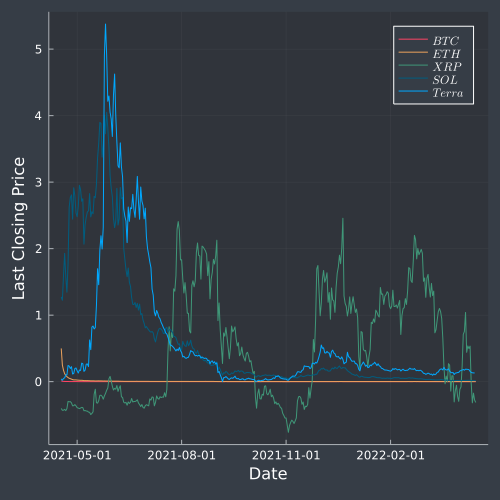

In [24]:
dr = Date(2021,04,17):Day(1):Date(2022,04,17)
plot()
for i in 2:5
    name_ = names(df)[i]
    plot!(reverse!(collect(dr)),df[!,i], label=L"%$name_")
end
plot!(reverse!(collect(dr))[2:366],df[2:366,6], label=L"Terra", xlabel= "Date", ylabel= "Last Closing Price", size = [500, 500])

### Q2

#### Formula of cryptocurrencies returns:
$$
return = \frac{closing\ price(t) - closing\ price(t-1)}{closing\ price(t-1)}
$$


In [25]:
r_list=return_cal(df)
cu_r_list = cumulative_return(r_list)

10-element Vector{Any}:
 -1.001056730521064
 -0.998296199526297
 -0.2231388725081389
 -0.9881843388264515
  2.058438115812508
 -0.25867608443852574
 -0.9788675429192087
 -1.0031343355069327
  5.305070491082108
 -6.336915358849395

In [ ]:
# The maximum cumulative return of all cryptocurrencies
index_ = findall(x->x == maximum(cu_r_list), cu_r_list) .+1
println("The most profitable  cryptocurrency is : $(names(dff)[index_])")

LoadError: BoundsError: attempt to access 4-element Vector{String} at index [[10]]

### Q2

In [ ]:
df[188, 1]

2021-10-12

In [26]:
r_df = DataFrame("Date" => reverse!(collect(Date(2021,10,12):Day(1):Date(2022,04,17))),
    "BTC" => first(r_list[1],188),
    "ETH" => first(r_list[2],188),
    "XRP" => first(r_list[3],188),
    "SOL" => first(r_list[4],188),
    "LUNA"=> first(r_list[5],188),
    "ADA" => first(r_list[6],188),
    "AVAX" => first(r_list[7],188),
    "DOT" => first(r_list[8],188),
    "DOGE" => first(r_list[9],188),
    "MATIC" => first(r_list[10],188),)

,Date,BTC,ETH,XRP,SOL,LUNA,ADA
,Date,Any,Any,Any,Any,Any,Any
1,2022-04-17,0.177694,0.00686586,0.127412,-0.00466651,-0.021311,0.0459204
2,2022-04-16,32.5269,-0.0321616,0.601238,-0.0350446,-0.0112759,0.485222
3,2022-04-15,-0.937156,0.10142,-0.455661,0.0135378,-0.013794,-0.137951
4,2022-04-14,-1.98798,-0.1556,11.4276,-0.0722963,-0.0415399,0.988604
5,2022-04-13,-0.827758,-0.181664,-1.04796,-0.161139,-0.10356,-3.10876
6,2022-04-12,-0.0158528,-0.0130808,0.0721179,-0.027786,-0.140841,-3.32667
7,2022-04-11,0.108682,-0.016653,-0.0715253,0.0340234,-0.0199051,0.216253
8,2022-04-10,-0.0802763,0.040577,0.217359,0.0153931,-0.00925676,-0.805721
9,2022-04-09,0.0161157,-0.0398795,-0.576249,-0.00511413,-0.0100744,-5.7648


In [27]:
positive_returns = []
negative_returns = []
for i in 2:11
    push!(positive_returns, df[findall(x->x<0 , r_df[!,i]), i])
    push!(negative_returns, df[findall(x->x>0 , r_df[!,i]), i])
end
println("number of positive returns are:")
for i in 1:10
    println("$(length(positive_returns[i]))")
end
println("number of negative returns are:")
for i in 1:10
    println("$(length(negative_returns[i]))")
end

number of positive returns are:
91
92
97
106
98
99
100
95
91
93
number of negative returns are:
97
96
91
82
90
89
88
93
97
95


In [28]:
positive_CuR = cumulative_return(positive_returns)
negative_CuR = cumulative_return(negative_returns)
println("altcoins cumulative return when the bitcoin daily return is pasitive:")
for i in 1:10
    println("$(positive_CuR[i])")
end
println("altcoins cumulative return when the bitcoin daily return is negative:")
for i in 1:10
    println("$(negative_CuR[i])")
end

altcoins cumulative return when the bitcoin daily return is pasitive:
0.0031915448800710067
0.11288732332238638
9.834714612242856e13
1443.8598259522578
3.081709470459692e7
1.2434199791758686e25
2199.62655042846
50.63554163767459
3.5255477099106084e6
4.535835754200475e24
altcoins cumulative return when the bitcoin daily return is negative:
0.003545247675871499
0.12114115276767534
3.652968880245465e16
564.3161323352107
1.0194910298431555e7
1.9090460629298006e23
2765.9698981256906
87.24222755016658
-1.2845951826414343e6
2.3877779797610988e28


### Q3

In [29]:
weights = collect(multiexponents(3, 20))/20
co_matrics = cov(hcat(r_df[!,2], r_df[!,3], r_df[!,4]))

3×3 Matrix{Float64}:
 5.70822      0.00696373    0.163724
 0.00696373   0.00813284   -0.065156
 0.163724    -0.065156    199.742

In [80]:
PortfolioVariance = [(transpose(weights[i]) * co_matrics* weights[i] ) for i in 1:length(weights)]
PortfolioReturn = [sum(weights[i][j] * cu_r_list[j] for j in 1:3) for i in 1:length(weights)]
risk_free_rate = 0.0
PortfolioSTD= .√(PortfolioVariance)
SharpRatio =  (PortfolioReturn .- risk_free_rate) ./ PortfolioSTD
best_weights = weights[findall(x-> x == maximum(SharpRatio),SharpRatio )]
println("The best weights are: $best_weights")


The best weights are: [[0.0, 0.0, 1.0]]


In [74]:
P_df = DataFrame("Weights" => weights, "PortfolioReturn" => PortfolioReturn, "PortfolioVariance" => PortfolioVariance, "SharpRatio" => SharpRatio)
CSV.write("DATA3.csv", P_df)

"DATA3.csv"

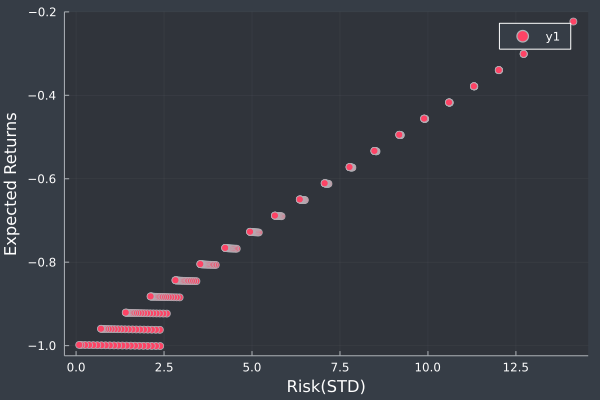

In [82]:
scatter( PortfolioSTD, PortfolioReturn, xlabel = "Risk(STD)", ylabel = "Expected Returns")

### Q4

In [114]:
function MovingAvg(start::Integer,step::Integer, df::DataFrame)
    N_series = []
    push!(N_series, df.BTC[start : start + step-1]...)
    for i in 1:100
        push!(N_series, mean(N_series[i:i+step-1]))
    end
    return N_series
end
AllNewPrices = []
start = 200
for step in 5:5:100
    NewPrices = MovingAvg(start , step, df)
    push!(AllNewPrices, NewPrices)
end

In [ ]:
MovingAvg

### Q5

In [83]:
function IsPrime(value::Integer)
    if value <= 1
        return false
    else
        for n in 2:value
            if value % n == 0
                return false
            end
        end
    end
    return true
end

IsPrime (generic function with 1 method)

### Q6

### Q7

#### A)

In [175]:
function GameResult(res)
    my_point = 0 
    your_point = 0
    for i in 1:5
        if res[i][1] != res[i][2]
            if (res[i][2] == 1 && res[i][1] == 3) || (res[i][2] == 3 && res[i][1] == 2) || (res[i][2] == 2 && res[i][1] == 1)
                my_point +=1 
            else
                your_point +=1
            end
        end
    end
    if my_point > your_point
        return "won!"
    elseif your_point > my_point
        return "failed!"
    else
        return "should try one more round!"
    end
end

GameResult (generic function with 1 method)

In [144]:
rounds = 5
shapes = ["rock", "paper", "scissors"]
res = []
for i in 1:rounds
    choice = parse(Int, readprompt("Enter your choice: 1)rock  2) paper  3)scissors:"))
    push!(res, (rand(1:3), choice))
end
println("you $(GameResult(res))")


you won!


#### B)

In [199]:
AllGameRes = []
for i in 1:1000
    res = []
    for i in 1:rounds
        push!(res, (rand(1:3), sample(1:3, Weights([1/6, 1/3, 1/2]))))
    end
    push!(AllGameRes, GameResult(res))
end


In [205]:
algorithms =Dict("weighted_algorithm"=> length(findall(x -> x == "won!", AllGameRes)),
             "unweighted_algorithm"=> length(findall(x -> x == "failed!", AllGameRes)))
for key in keys(algorithms)
    if algorithms[key] == max(algorithms["weighted_algorithm"], algorithms["unweighted_algorithm"])
     println("The algorithm that won is: {$key} with the number of wines: $(algorithms[key]). ")
    end
end

The algorithm that won is: {weighted_algorithm} with the number of wines: 395. 
